In [1]:
from muselsl import stream, list_muses, view, record
from multiprocessing import Process
from mne import Epochs, find_events
from time import time, strftime, gmtime
import os
from stimulus_presentation import n170
from utils import utils
from collections import OrderedDict
import warnings
warnings.filterwarnings('ignore')

# N170

This notebook will run an N170 experiment to analyze event-related potentials indicating the processing of faces.

    The N170 was first described by Shlomo Bentin and colleagues in 1996,[5] who measured ERPs from participants viewing faces and other objects. They found that human faces and face parts (such as eyes) elicited different responses than other stimuli, including animal faces, body parts, and cars.

# Step 1: Connect to an EEG Device
*Note: if using Windows 10 and BlueMuse, skip this section and connect using the BlueMuse GUI*

Make sure your device is turned on and run the following code. It should detect and connect to the device and begin 'Streaming...'

If the device is not found or the connection times out, try running this code again

In [2]:
# Search for available Muse devices
muses = list_muses()

Starting BlueMuse, see BlueMuse window for interactive list of devices.


In [ ]:
# Start a background process that will stream data from the first available Muse
stream_process = Process(target=stream, args=(muses[0]['address'],))
stream_process.start()

# Step 2: Apply the EEG Device and Wait for Signal Quality to Stabilize
Put the Muse on and run the following code to view the raw EEG data stream.

The numbers on the side of the graph indicate the variance of the signal. Wait until this decreases below 10 for all electrodes before proceeding.

In [3]:
%matplotlib tk
view()

Looking for an EEG stream...
Start acquiring data.

                toggle filter : d
                toogle full screen : f
                zoom out : /
                zoom in : *
                increase time scale : -
                decrease time scale : +
               


# Step 3: Run the Experiment
Modify the variables in the following code chunk to define how long you want to run the experiment and the name of the subject and session you are running. Then, seat the subject in front of the computer and have them quietly view the screen until the experiment is completed.

Stimuli were presented for 200 ms with an intertrial interval of 400 ms and random jitter of ±100ms. The task was to mentally note whether a “face” or a “house” was presented. Six blocks of 2 min were recorded for a single partipant.

The stimuli set consisted in 12 grayscale pictures of centered human faces for the “face” condition, and in 12 grayscale pictures of houses for the “face” condition. The pictures were obtained from:

In [3]:
# Define these parameters 
duration = 120
subject = 11
session = 1

In [5]:
recording_path = os.path.join(os.path.expanduser("~"), "eeg-notebooks", "data", "visual", "N170", "subject" + str(subject), "session" + str(session), ("recording_%s.csv" %
                                              strftime("%Y-%m-%d-%H.%M.%S", gmtime())) + ".csv")

stimulus = Process(target=n170.present, args=(duration,))
recording = Process(target=record, args=(duration, recording_path))

stimulus.start()
recording.start()

# Step 4: Clean the Data

## Load data into MNE objects

In [4]:
raw = utils.load_data('visual/N170', sfreq=256., 
                      subject_nb=subject, session_nb=session)

Creating RawArray with float64 data, n_channels=5, n_times=30564
    Range : 0 ... 30563 =      0.000 ...   119.387 secs
Ready.


## Power Spectrum

Effective window size : 8.000 (s)


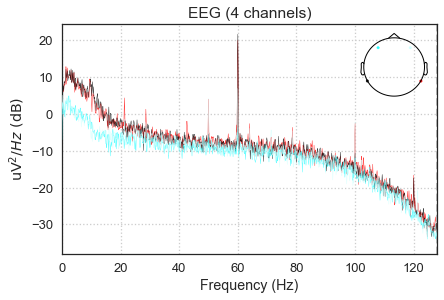

In [5]:
%matplotlib inline
raw.plot_psd();

## Filtering
Filter the data between 1 and 30hz

In [6]:
raw.filter(1,30, method='iir')

Setting up band-pass filter from 1 - 30 Hz


<RawArray  |  None, n_channels x n_times : 5 x 30564 (119.4 sec), ~1.2 MB, data loaded>

## Epoching

Here we epoch data for -100ms to 800ms after the stimulus. No baseline correction is needed (signal is bandpass filtered) and we reject every epochs were the signal exceed 75 uV. This mainly rejects blinks.

In [7]:
events = find_events(raw)
event_id = {'House': 1, 'Face': 2}

epochs = Epochs(raw, events=events, event_id=event_id, 
                tmin=-0.1, tmax=0.8, baseline=None,
                reject={'eeg': 100e-6}, preload=True, 
                verbose=False, picks=[0,1,2,3])
print('sample drop %: ', (1 - len(epochs.events)/len(events)) * 100)
epochs

192 events found
Event IDs: [1 2]
('sample drop %: ', 100)


<Epochs  |   180 events (all good), -0.101562 - 0.800781 sec, baseline off, ~1.3 MB, data loaded,
 'Face': 94
 'House': 86>

# Step 5: Analyze the Data

Now we can analyze our results by averaing the epochs and looking for differences between epochs when faces or houses were presented


## Epoch average

Now we can plot the average ERP for both conditions:

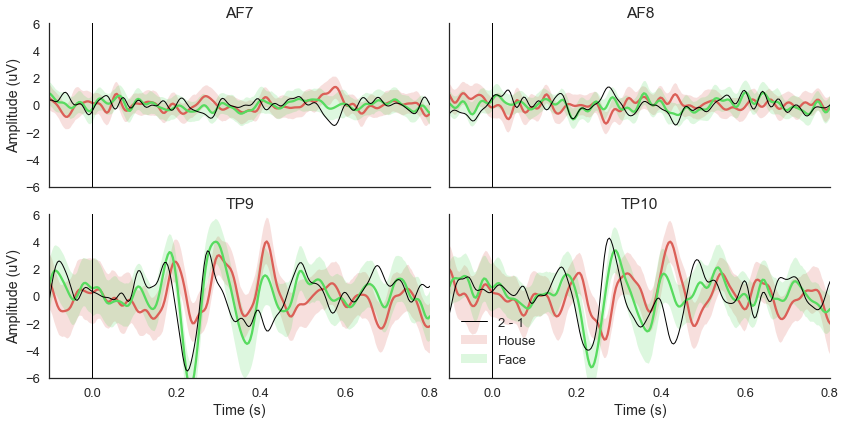

In [8]:
%matplotlib inline
conditions = OrderedDict()
conditions['House'] = [1]
conditions['Face'] = [2]

fig, ax = utils.plot_conditions(epochs, conditions=conditions, 
                                ci=97.5, n_boot=1000, title='',
                                diff_waveform=(1, 2))

 ## What do you see? Describe the shape of the waveform